# Prediction Ice Cream Sales with Linear Regression



Data set has 2 input features: Temperature in °C and Is Weekend flag (0/1).
Target is called Ice Creams Sold.

Neural network used can only have single input layer and single output layer without activation functions.

## Set up environment

In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.draw_graph import draw_dot
from src.model.builder import build_regression_model
from src.model.training import train_model
from src.model.evaluation import evaluate_model
from src.model.hp_tuning import start_hp_search

import random
random.seed(42)

import numpy as np
np.random.seed(42) 

import pandas as pd
from pandas import DataFrame

from matplotlib import pyplot as plt

## Hyperparams

In [2]:
TEST_SIZE = 0.1

# 1e-2 is too high for more than one neuron (exploding gradients)
# 1e-3 makes training too erratic (jumping around minimum)
LEARNING_RATE = 1e-4
BATCH_SIZE = 8

EPOCHS = 1000

EARLY_STOPPING_PATIENCE = 10
EARLY_STOPPING_DELTA = 1e-3

HIDDEN_LAYERS_NUM = 0
HIDDEN_NEURONS_NUM = 0

## Load data

In [3]:
df = pd.read_csv("ice_cream_data.csv", sep=",")
df = df.sample(frac=1, random_state=42)
df.head()

,Temperature,Is_Weekend,Ice_Creams_Sold
110,18.692544,1,203
419,32.571236,0,275
565,27.697531,1,274
77,12.221340,0,104
181,13.404206,0,136


### Separate input from target

In [4]:
targets = df["Ice_Creams_Sold"]
inputs = df.drop(["Ice_Creams_Sold"], axis=1)

In [5]:
inputs.min()

Temperature    10.151848
Is_Weekend      0.000000
dtype: float64

In [6]:
inputs.max()

Temperature    39.99153
Is_Weekend      1.00000
dtype: float64

### Normalize input

In [7]:
def normalize_input(X: DataFrame):
    result = (X - X.min()) / (X.max() - X.min())
    return result

In [8]:
norm_inputs = normalize_input(inputs)

In [9]:
norm_inputs.min()

Temperature    0.0
Is_Weekend     0.0
dtype: float64

In [10]:
norm_inputs.max()

Temperature    1.0
Is_Weekend     1.0
dtype: float64

### Numpy

In [11]:
inputs = norm_inputs.to_numpy()
inputs[:5]

array([[0.2862194 , 1.        ],
       [0.75132798, 0.        ],
       [0.58799831, 1.        ],
       [0.06935369, 0.        ],
       [0.10899439, 0.        ]])

In [12]:
inputs.shape

(600, 2)

In [13]:
n_inputs = inputs.shape[1]

In [14]:
targets = targets.to_numpy()
targets[:5]

array([203, 275, 274, 104, 136])

### Train vs. Test set

In [15]:
test_size = int(len(inputs) * TEST_SIZE)
print(f"Train size: {len(inputs) - test_size}, Test size: {test_size}")

inputs_train = inputs[:-test_size]
targets_train = targets[:-test_size]

inputs_test = inputs[-test_size:]
targets_test = targets[-test_size:]

Train size: 540, Test size: 60


## Train Model

### Hyperparameter tuning

In [16]:

# Grid Search
hp_grid = {
    "learning_rate": [5e-1, 1e-1, 5e-2, 1e-2, 5e-3, 1e-3],
    "batch_size": [8, 16, 32, 64, 128, 256]
}

def train_and_evaluate(hp_config):
    inputs, target, _, loss = build_regression_model(n_inputs, HIDDEN_LAYERS_NUM, HIDDEN_NEURONS_NUM)
    train_model(inputs_train, inputs_test, targets_train, targets_test, EPOCHS, hp_config["batch_size"], hp_config["learning_rate"], inputs, target, loss, EARLY_STOPPING_PATIENCE, EARLY_STOPPING_DELTA, log=False)
    average_loss = evaluate_model(inputs_test, targets_test, inputs, target, loss)
    return average_loss

best_hp_config = start_hp_search(hp_grid, train_and_evaluate)

Search iteration: 1
Testing config: {'learning_rate': 0.5, 'batch_size': 8}
Loss: 256.753868899786
Search iteration: 2
Testing config: {'learning_rate': 0.5, 'batch_size': 16}
Loss: 528.4602997519781
Search iteration: 3
Testing config: {'learning_rate': 0.5, 'batch_size': 32}
Loss: 440.5060191553119
Search iteration: 4
Testing config: {'learning_rate': 0.5, 'batch_size': 64}
Loss: 290.4493206068572
Search iteration: 5
Testing config: {'learning_rate': 0.5, 'batch_size': 128}
Loss: 259.86738817097813
Search iteration: 6
Testing config: {'learning_rate': 0.5, 'batch_size': 256}
Loss: 382.63223821665173
Search iteration: 7
Testing config: {'learning_rate': 0.1, 'batch_size': 8}
Loss: 173.81850707652387
Search iteration: 8
Testing config: {'learning_rate': 0.1, 'batch_size': 16}
Loss: 175.68982821518594
Search iteration: 9
Testing config: {'learning_rate': 0.1, 'batch_size': 32}
Loss: 174.68118544629473
Search iteration: 10
Testing config: {'learning_rate': 0.1, 'batch_size': 64}
Loss: 176

In [17]:
batch_size = best_hp_config["batch_size"]
print(f"Best batch size config: {batch_size}")

learning_rate = best_hp_config["learning_rate"]
print(f"Best learning rate: {learning_rate}")

Best batch size config: 64
Best learning rate: 0.05


### Training

In [18]:
inputs, target, output, loss = build_regression_model(n_inputs, HIDDEN_LAYERS_NUM, HIDDEN_NEURONS_NUM)

history = train_model(inputs_train, inputs_test, targets_train, targets_test, EPOCHS, batch_size, learning_rate, inputs, target, loss, EARLY_STOPPING_PATIENCE, EARLY_STOPPING_DELTA)

Epoch 0: loss=22114.72656792045, test_loss=inf
Epoch 1: loss=3266.123618680239, test_loss=5439.93119579305
Epoch 2: loss=1941.813766018566, test_loss=2365.3392077371145
Epoch 3: loss=1637.4694288540916, test_loss=1739.434664497098
Epoch 4: loss=1612.3054798347432, test_loss=1509.8818802664887
Epoch 5: loss=1370.9194591808275, test_loss=1249.5985971414593
Epoch 6: loss=1302.7533378165438, test_loss=1134.425120558547
Epoch 7: loss=1269.8386213907156, test_loss=1373.003572484143
Epoch 8: loss=1066.828535834132, test_loss=1054.4940667034302
Epoch 9: loss=895.5423425860048, test_loss=871.7769222010713
Epoch 10: loss=896.31033435134, test_loss=875.2336781197798
Epoch 11: loss=727.5509512850506, test_loss=605.2566882423719
Epoch 12: loss=620.7234169961117, test_loss=554.5256747841319
Epoch 13: loss=611.9497309892558, test_loss=499.4574946139107
Epoch 14: loss=527.2008974676587, test_loss=417.0175539860928
Epoch 15: loss=471.80415852230215, test_loss=425.7162382650092
Epoch 16: loss=469.333775

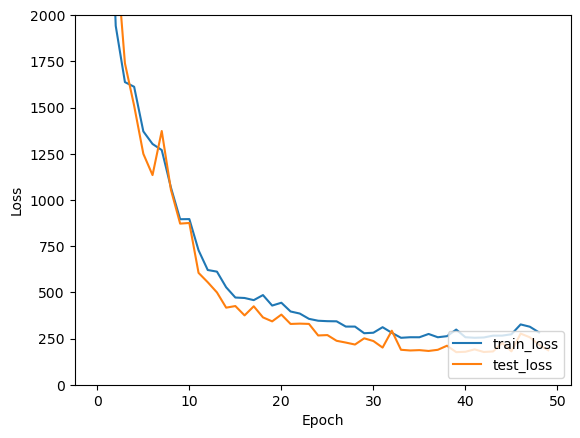

In [19]:
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["test_loss"], label="test_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(0, 2000)
plt.legend(loc="lower right")

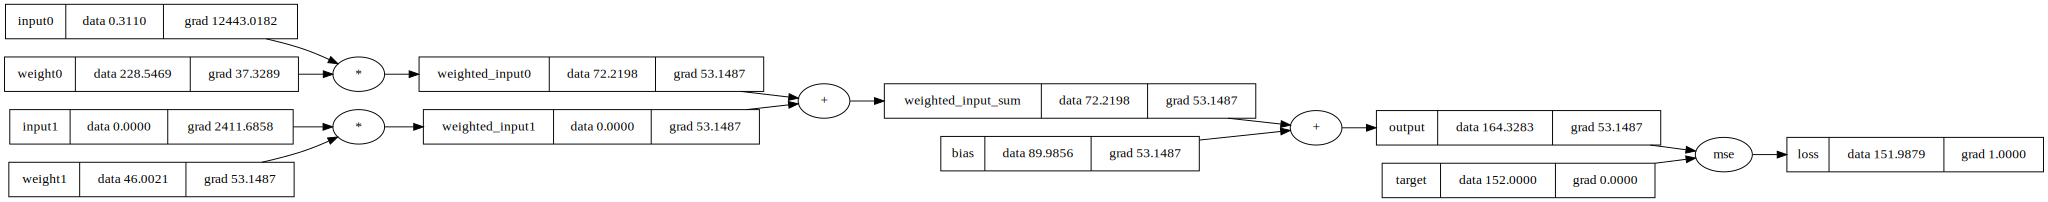

In [20]:
draw_dot(loss)

## Test solution

In [21]:
average_loss = evaluate_model(inputs_test, targets_test, inputs, target, loss)

In [22]:
rmse = np.sqrt(average_loss)
mean_target = np.mean(targets)
print("RMSE:", rmse)
print("Mean of targets:", mean_target)
print("Error as percentage of mean:", rmse / mean_target * 100)

RMSE: 13.275932639606083
Mean of targets: 216.425
Error as percentage of mean: 6.134195513275306
